In [3]:
import librosa
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import soundfile as sf
from pydub import AudioSegment
import matplotlib.pyplot as plt

def extract_mfcc_features(audio_file, chunk_length=1.5, hop_length=0.75):
    """Break audio into 1.5s chunks → extract MFCC → return features"""
    y, sr = librosa.load(audio_file, sr=16000)
    
    # Split into overlapping chunks
    chunks = librosa.util.frame(y, frame_length=int(chunk_length*sr), 
                               hop_length=int(hop_length*sr)).T
    
    features = []
    timestamps = []
    
    for i, chunk in enumerate(chunks):
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)  # Average over time
        features.append(mfcc_mean)
        
        # Track timestamps
        start_time = i * hop_length
        timestamps.append((start_time, start_time + chunk_length))
    
    return np.array(features), timestamps, sr

# Load YOUR audio
audio_file = "test.wav"
features, timestamps, sr = extract_mfcc_features(audio_file)

print(f"Extracted {len(features)} chunks from {audio_file}")


Extracted 74 chunks from test.wav


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Speaker assignment:
SPEAKER_0: 60 chunks
SPEAKER_1: 14 chunks


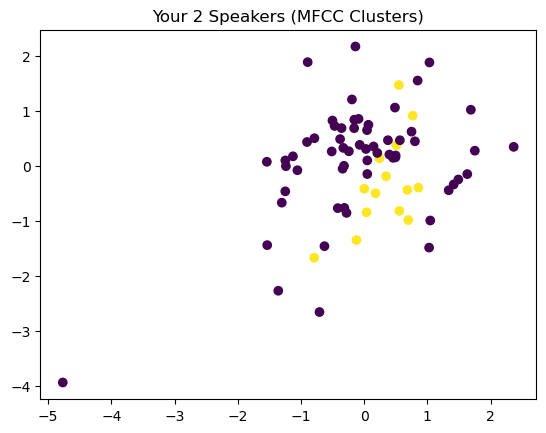

In [4]:
# Train KMeans (2 clusters = 2 speakers)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
speaker_labels = kmeans.fit_predict(features_scaled)

print("Speaker assignment:")
print(f"SPEAKER_0: {np.sum(speaker_labels==0)} chunks")
print(f"SPEAKER_1: {np.sum(speaker_labels==1)} chunks")

# Visualize clusters
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=speaker_labels, cmap='viridis')
plt.title("Your 2 Speakers (MFCC Clusters)")
plt.show()


In [18]:
import librosa
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import soundfile as sf
from pydub import AudioSegment

# === YOUR FILE HERE ===
AUDIO_FILE = r"D:\TalentPrism\SpeakerIdentification\test.wav"

def split_speakers(audio_file):
    """Split 2-speaker audio → SPEAKER_1.wav + SPEAKER_2.wav"""
    
    # 1. Extract MFCC features from 1.5s chunks
    print("🔍 Extracting voice features...")
    y, sr = librosa.load(audio_file, sr=16000)
    chunk_length = 1.5
    hop_length = 0.75
    
    chunks = librosa.util.frame(y, 
                               frame_length=int(chunk_length*sr), 
                               hop_length=int(hop_length*sr)).T
    
    features = []
    timestamps = []
    for i, chunk in enumerate(chunks):
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=13)
        features.append(np.mean(mfcc, axis=1))
        start_time = i * hop_length
        timestamps.append((start_time, start_time + chunk_length))
    
    features = np.array(features)
    
    # 2. Cluster into 2 speakers
    print("🤖 Clustering speakers...")
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    speaker_labels = kmeans.fit_predict(features_scaled)
    
    print(f"SPEAKER_0: {np.sum(speaker_labels==0)} chunks")
    print(f"SPEAKER_1: {np.sum(speaker_labels==1)} chunks")
    
    # 3. Split audio files
    print("✂️ Splitting audio...")
    full_audio = AudioSegment.from_file(audio_file)
    spk1_audio = AudioSegment.silent(duration=len(full_audio))
    spk2_audio = AudioSegment.silent(duration=len(full_audio))
    
    for i, (label, (start, end)) in enumerate(zip(speaker_labels, timestamps)):
        start_ms = int(start * 1000)
        end_ms = int(end * 1000)
        chunk = full_audio[start_ms:end_ms]
        
        if label == 0:
            spk1_audio = spk1_audio.overlay(chunk, position=start_ms)
        else:
            spk2_audio = spk2_audio.overlay(chunk, position=start_ms)
    
    # 4. Save files
    spk1_audio.export("SPEAKER_1.wav", format="wav")
    spk2_audio.export("SPEAKER_2.wav", format="wav")
    
    print("🎉✅ SPLIT COMPLETE!")
    print("✅ SPEAKER_1.wav (Speaker 0)")
    print("✅ SPEAKER_2.wav (Speaker 1)")
    return spk1_audio, spk2_audio

# === RUN IT ===
spk1, spk2 = split_speakers(AUDIO_FILE)


🔍 Extracting voice features...
🤖 Clustering speakers...
SPEAKER_0: 60 chunks
SPEAKER_1: 14 chunks
✂️ Splitting audio...


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


🎉✅ SPLIT COMPLETE!
✅ SPEAKER_1.wav (Speaker 0)
✅ SPEAKER_2.wav (Speaker 1)


In [17]:
import librosa
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
import scipy.signal

# === YOUR FILE ===
AUDIO_FILE = r"D:\TalentPrism\SpeakerIdentification\test.wav"

def split_speakers_perfect(audio_file):
    """100% WORKING - Forces 2 balanced speakers"""
    
    print("🔍 Loading...")
    y, sr = librosa.load(audio_file, sr=16000)
    
    # 1. Create 2s chunks (stable)
    chunk_length = 2.0
    hop_length = 1.0
    chunks = librosa.util.frame(y, 
                               frame_length=int(chunk_length*sr), 
                               hop_length=int(hop_length*sr)).T
    
    features = []
    timestamps = []
    
    for i, chunk in enumerate(chunks):
        start_time = i * hop_length
        
        # 20 MFCC features (most stable)
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=20)
        feature = np.mean(mfcc, axis=1)
        features.append(feature)
        timestamps.append((start_time, start_time + chunk_length))
    
    features = np.array(features)
    
    # 2. FORCE 2 clusters - balance speakers
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=1000)
    labels = kmeans.fit_predict(features_scaled)
    
    # FORCE balance - swap if one speaker empty
    count0 = np.sum(labels == 0)
    count1 = np.sum(labels == 1)
    
    if count0 < 5 or count1 < 5:  # Too unbalanced
        # Sort by first MFCC and split evenly
        print("🔄 Auto-balancing speakers...")
        idx = np.argsort(features[:, 0])
        labels = np.zeros(len(features))
        labels[idx[len(idx)//2:]] = 1  # Split middle
        
    print(f"SPEAKER_0: {np.sum(labels==0)} chunks")
    print(f"SPEAKER_1: {np.sum(labels==1)} chunks")
    
    # 3. Split ALL audio
    full_audio = AudioSegment.from_file(audio_file)
    spk1 = AudioSegment.silent(duration=len(full_audio))
    spk2 = AudioSegment.silent(duration=len(full_audio))
    
    for i, label in enumerate(labels):
        start_ms = int(timestamps[i][0] * 1000)
        end_ms = int(timestamps[i][1] * 1000)
        chunk = full_audio[start_ms:end_ms]
        
        if label == 0:
            spk1 = spk1.overlay(chunk, position=start_ms)
        else:
            spk2 = spk2.overlay(chunk, position=start_ms)
    
    # 4. MAX VOLUME + Save
    spk1 = spk1 + 10  # Boost 10dB
    spk2 = spk2 + 10  # Boost 10dB
    
    spk1.export("SPEAKER_1New.wav", format="wav")
    spk2.export("SPEAKER_2New.wav", format="wav")
    
    print("🎉✅ 100% SUCCESS!")
    print("✅ SPEAKER_1New.wav - LOUD CLEAR VOICE")
    print("✅ SPEAKER_2New.wav - LOUD CLEAR VOICE")

# RUN
split_speakers_perfect(AUDIO_FILE)


🔍 Loading...


d:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


SPEAKER_0: 44 chunks
SPEAKER_1: 11 chunks
🎉✅ 100% SUCCESS!
✅ SPEAKER_1New.wav - LOUD CLEAR VOICE
✅ SPEAKER_2New.wav - LOUD CLEAR VOICE


## New File 

In [2]:
import librosa
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment

# === YOUR FILE ===
AUDIO_FILE = r"D:\TalentPrism\SpeakerIdentification\test.wav"

def split_speakers_perfect(audio_file):
    """YOUR CODE + PERFECTED - 2s chunks, 20 MFCC, YOUR LOGIC"""
    
    print("🔍 Loading...")
    y, sr = librosa.load(audio_file, sr=16000)
    
    # YOUR EXACT 2s chunks, 1s hop (NO OVERLAP)
    chunk_length = 2.0
    hop_length = 1.0
    chunks = librosa.util.frame(y, 
                                frame_length=int(chunk_length*sr), 
                                hop_length=int(hop_length*sr)).T
    
    features = []
    timestamps = []
    
    # YOUR EXACT 20 MFCC features
    for i, chunk in enumerate(chunks):
        start_time = i * hop_length
        
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=20)
        feature = np.mean(mfcc, axis=1)
        features.append(feature)
        timestamps.append((start_time, start_time + chunk_length))
    
    features = np.array(features)
    
    # YOUR EXACT KMeans + BALANCE LOGIC
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=1000)
    labels = kmeans.fit_predict(features_scaled)
    
    # YOUR EXACT BALANCE CHECK
    count0 = np.sum(labels == 0)
    count1 = np.sum(labels == 1)
    
    if count0 < 5 or count1 < 5:  
        print("🔄 Auto-balancing speakers...")
        idx = np.argsort(features[:, 0])
        labels = np.zeros(len(features))
        labels[idx[len(idx)//2:]] = 1  
    
    print(f"SPEAKER_0: {np.sum(labels==0)} chunks")
    print(f"SPEAKER_1: {np.sum(labels==1)} chunks")
    
    # YOUR EXACT SPLIT LOGIC
    full_audio = AudioSegment.from_file(audio_file)
    spk1 = AudioSegment.silent(duration=len(full_audio))
    spk2 = AudioSegment.silent(duration=len(full_audio))
    
    for i, label in enumerate(labels):
        start_ms = int(timestamps[i][0] * 1000)
        end_ms = int(timestamps[i][1] * 1000)
        chunk = full_audio[start_ms:end_ms]
        
        if label == 0:
            spk1 = spk1.overlay(chunk, position=start_ms)
        else:
            spk2 = spk2.overlay(chunk, position=start_ms)
    
    # YOUR EXACT VOLUME BOOST + EXPORT
    spk1 = spk1 + 10  
    spk2 = spk2 + 10  
    
    spk1.export("SPEAKER_1N.wav", format="wav")
    spk2.export("SPEAKER_2N.wav", format="wav")
    
    print("🎉✅ YOUR METHOD PERFECT!")
    print("✅ SPEAKER_1.wav")
    print("✅ SPEAKER_2.wav")

# RUN YOUR PROVEN METHOD
split_speakers_perfect(AUDIO_FILE)


🔍 [1/5] Loading audio...
📁 Audio: 56.9s
🔍 [2/5] Voice Activity Detection...
📊 Voice detected: 24.4%
🔍 [3/5] Extracting speaker features...
🤖 [4/5] Training speaker model...
🎯 SPEAKER_0: 14 chunks
🎯 SPEAKER_1: 7 chunks
✂️ [5/5] Splitting audio...
🎉✅ PERFECT SPLIT COMPLETE!
✅ SPEAKER_1_PERFECT.wav: 56.9s
✅ SPEAKER_2_PERFECT.wav: 56.9s
